CODE for optimal compression Ratio

Flow of the program:
1. Compress the Image with some arbitrary quality parameter like 10 in WEBP format
2. Calculate the compression ratio and SIFT features.
3. Calculate the SIFT features of uncomressed image
4. Calculate the % reduction in them
5. calculate the FPS based on the compressed size
6. if less than desired then compress more (reduce the quality parameter)
7. if more then desired then compress less (increase the quality parameter)

Problem:
1. SIFT and SSIM calculation will take additional time of their own.

Solution
1. FAST feature instead of SIFT
2. First need to check if there is strong correlation in the FAST and SIFT features
3. if yes then we do FAST for calculation of parameters else not


Need to perform this calculation incrementally not in a batch to demonstrate the bandwidth changes and the change of compression ratio 

In [122]:
#import modules
import os
import time
import cv2 
import numpy as np
import random
from PIL import Image
from io import BytesIO
from skimage.metrics import structural_similarity as ssim 


In [123]:
#read the images from the directory

def file_handling(path):
    """
    path to the images dataset
    """
    #org_dir=os.getcwd()

    #changing to the dataset dir
    try:
        os.chdir(path)
    except:
        print("Path not valid")
        return

    files=os.listdir(path) #files in the directory
    images=[] #getting only the jpg and png images
    for file in files:
        if file.lower().endswith(".jpeg") or file.lower().endswith(".jpg") \
        or file.lower().endswith(".png") or file.lower().endswith(".webp") \
        or file.lower().endswith(".avif"):
            images.append(file)

    print("Images in dataset:",len(images))
    if len(images)!=0:
        print("First filename:",images[0])
    else:
        print("No images in the path or different format")
    
    #go to the original directory back
    #os.chdir(org_dir)
    
    return images, path

def output_dir(path,dir_name="output"):
    """
        Create an output directory and 
        if already exists then remove the existing files

        Default name of the output directory is "output"
    """
    dir_name=os.path.join(path,dir_name)
    try:
        os.mkdir(dir_name)
    except:
        print("Directory already exists- Removing the existing files")
        files=os.listdir(dir_name)
        for file in files:
            os.remove(os.path.join(dir_name,file))
        print("files_removed")
    return dir_name

In [124]:
def calculate_ssim(img_org,img_recon):
    """
    img_org and img_recon are the path of the 
    original image and the reconstructed image
    """
    img_org=np.asarray(img_org)
    img_recon=np.asarray(img_recon)
    #print("org:",img_org.size)
    #print("recon:",img_recon.size)
        
    ssim_value=ssim(img_org,img_recon,win_size=3) #for 3 channel
    #print("SSIM:",ssim_value)
    return ssim_value

In [125]:
def sift(img):
    '''
    Function can draw keypoints on the image too, 
    but calculation is commented.
    '''

    image=img.convert("L")
    image=np.asarray(image)
    
    sift=cv2.SIFT.create() #initiate SIFT detector

    #Find keypoints on the image
    keypoints,descriptors=sift.detectAndCompute(image,None)

    #Draw keypoints on the image
    #image_with_sift=cv2.drawKeyPoints(image.copy(),keypoints,None,(255,0,0),4)

    return keypoints#,image_with_sift


def fast(img):
    '''
    Function can draw keypoints on the image too, 
    but calculation is commented.
    '''

    image=img.convert("L")
    image=np.asarray(image)
    
    fast=cv2.FastFeatureDetector_create() #initiate SIFT detector

    #Find keypoints on the image
    keypoints=fast.detect(image)

    return keypoints


In [160]:
def quality_increment_calculation(bandwidth,img_size,comp_time,q_prev,coeffs):
    """
        Function to calculate the appropriate 
        increment or decrement in the quality level
        according to the bandwidth.

        coeffs is the coefficients of the fitted polynomial to the 
        calibration data (quality parameter of the WEBP and the compression ratio
    """
    #get the value of the bandwidth used last time
    compressed_image_size_desired=bandwidth*comp_time #size in MegaBits where the bandwidth is in Mbps and time in seconds
    img_org_size=(img_size*8)/(1000000) #convert to Mega bits
    print("Img_org_size:",img_org_size)
    compression_ratio=img_org_size/compressed_image_size_desired
    degree=3
    #from the fitted function we get the quality parameter
    quality=predict_value(coeffs,compression_ratio,degree)
    print("Quality is:",quality)
    return quality
    
    #get the remaining bandwidth 
    #get the last quality level used
    #get the appropriate quality level

In [162]:
#incrementally provide images to the compression module

def image_compression(dataset_path,calib_data):

    #get the images from the dataset_path
    images,path=file_handling(dataset_path)
    
    #bandwidth
    bandwidth=5 #5Mbps
    #image compression time
    comp_time=0.5 #in seconds
    
    if len(images)!=0:
        img_size=os.path.getsize(os.path.join(path,images[0]))
    #this img_size is the size of the uncompressed image 
    #used for the purpose of calibration

    #previous  value of quality parameter , using 10 arbitrarily for the initialization
    q_prev=10

    #Fitting the ploynomial in the calibration data
    x=calib_data["CR"]
    y=calib_data["Quality"]
    
    #fitting the polynomial to these data
    start=time.time()
    coeffs,y_fit,degree=fit_polynomial(x,y,3)
    end=time.time()
    print("Polynomial fitting time:",round(end-start,3),"seconds")
    plotting_data_fit(x,y,y_fit,coeffs,"WEBP compression Ratio","WEBP quality parameter")
    
    
    quality=quality_increment_calculation(bandwidth,img_size,comp_time,q_prev,coeffs)

    #generate some random sleep time for simulating the network delay
    delay_time=random.randint(1,4)

    #creating the output directory
    output_dir_name=output_dir(path,dir_name="output")

    #initial value of quality taken abitrarily
    #quality=10
    

    
    for img in images:
        time.sleep(delay_time)

        image_path=os.path.join(path,img)
        img_size=os.path.getsize(image_path) #get the size of the image in the disc
        
        quality=quality_increment_calculation(bandwidth,img_size,comp_time,q_prev,coeffs)
        print("Quality calculated in the image_compression function :",quality)
        q_prev=quality
        
        
        start=time.time()
        metric_data,img_recon,compressed_size=compression_driver(image_path,quality=quality)
        end=time.time()
        comp_time=round(end-start,4)
        print("Compression time: ",comp_time,"seconds")
        
        #Save the webp image to the disc
        img_recon_path=os.path.join(output_dir_name,img)
        img_recon.save(img_recon_path,"WEBP",quality=quality)

        compressed_size=compressed_size*8 #convert to bits
        print("Compressed_size:",compressed_size,"bits")
        current_bandwidth=compressed_size/(1000000*round(end-start,2))
        print("bandwidth_consumed:",current_bandwidth,"Mbps")

        diff=bandwidth-current_bandwidth #difference in the bandwidth
        print("Remaining bandwidth:",diff,"Mbps")

        print("\n=================================================================\n")
        
        #if diff>0: #slack hence increase the quality
            #increase the quality
        #    quality+=10 #arbitrarily chosing quality to increase by 10
        #elif diff<0: #less bandwidth
        #    quality-=10 #decrease the quality
        #else:
        #    print("Demand and supply matches- NO change\n")
        

        
        
        
    #read the image from the list of images
    #artificial delay 
    #provide the file to the compression code


In [128]:
def compression_driver(image_path,quality=5):
    #quality=10 #arbitrary
    #quality=10
    
    #Open and Resize the image
    start=time.time()
    img_org=Image.open(image_path)
    size=(1920,1080)
    img_org=img_org.resize(size)

    #Compress the image
    estimated_size,webp_data=compress(img_org,quality)
    img_recon=webp_data
    end=time.time()
    print("Img compression: ",round(end-start,2))
    
    #Calculate Metrics
    start=time.time()
    uncomp_size=os.path.getsize(image_path)
    CR=uncomp_size/estimated_size # calculated the compression ratio
    end=time.time()
    print("CR: ",round(end-start,2))

    
    
    #SSIM metric  SKIP due to long calculation time
    #here the recon_image is in the buffer format
    #start=time.time()
    #ssim_value=calculate_ssim(img_org,img_recon)
    #print(f"ssim:{ssim_value}, CR: {CR}")
    #end=time.time()
    #print("SSIM: ",round(end-start,2))

    #Features using FAST
    start=time.time()
    keypoints=fast(img_org)
    KP_o=len(keypoints)
    keypoints=fast(img_recon)
    KP_r=len(keypoints)
    end=time.time()
    
    print("Features: ",round(end-start,2))
    print(f"KP O {KP_o} KP_R {KP_r}")

    KP_per_red=(((KP_o)-(KP_r))/(KP_o))*100
    print(f"KP % red {KP_per_red}")

    Metric=KP_per_red/CR # Metric used for deciding the quality of compression
                        #Lower is Better
                        #KF_per_red should be low and CR should be high for better quality compression
    
    return Metric,img_recon,estimated_size
    
    #find out the FPS and bandwidth 
    #adjust the compression ratio for further computation by deciding new quality parameter


In [129]:
def compress(img_org,quality=5):
    #compress the image using the traditional method (WEBP for now)
    #image=Image.open(image_path)
    #print(f"size:{size/1000}")

    #create an in-memory buffer for the WEEBP data
    
    buffer=BytesIO()
    
    #compress the image to WEBP format
    start=time.time()
    img_org.save(buffer,format="WEBP",quality=quality)
    end=time.time()
    

    #Get the size of the in-memory buffer for potential further usage
    estimated_size=buffer.tell()

    #reset the buffer to the beginning for potential further usage
    buffer.seek(0)

    #Convert the buffer to the PIL image
    webp_data=Image.open(buffer)

    #close the buffer
    buffer.close()
    

    return estimated_size, webp_data


image_path=r"C:\Swapnil\Narrowband_DRONE\compression_experiment\images\000000_left.png"
#img_org=Image.open(image_path)

#estimated_size,webp_data=compression_body(img_org)







    

In [130]:
def calibration_function(image_path):
    """
        Function to calibrate the size of the image with the 
        quality parameter for the WEBP codec
        Output List of the image sizes, compression ratio with the
        quality parameter
        """
    #get the image and convert to the IO buffer
    img_org=Image.open(image_path)            #read the image
    org_image_size=os.path.getsize(image_path)
    quality_fine=[i for i in range(10)] #quality 1 to 10
    quality_coarse=[] #quality 15 to 100 with interval of 5
    for i in range(10,100,5):
        i=i+5
        quality_coarse.append(i)
    quality_fine.extend(quality_coarse) #list of quality parameter from 1 to 10 and 15 to 100 in interval of 1 and 5 respectively
    quality_final=quality_fine
    calib_data={} #dictionary to store the calibration data
    estimated_size_lst=[] 
    cr_lst=[]
    #run the compress function with respect to the quality_final
    for q in quality_final:
        estimated_size,webp_data=compress(img_org,quality=q)
        estimated_size_lst.append(estimated_size)
        cr_lst.append(org_image_size/estimated_size)
    calib_data["Quality"]=quality_final
    calib_data["Compressed_size"]=estimated_size_lst
    calib_data["CR"]=cr_lst
    print("Calibration data:")
    print(calib_data)
    #change the quality parameter and save populate the list of image sizes and compression ratio
    return calib_data

import os
from PIL import Image
image_path=r"C:\Swapnil\Narrowband_DRONE\compression_experiment\images\000000_left.png"
start=time.time()
calib_data=calibration_function(image_path)
end=time.time()
print("Execution time:",round(end-start,2))

Calibration data:
{'Quality': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'Compressed_size': [148866, 235370, 264036, 286380, 305746, 324574, 342396, 358128, 371262, 384620, 452000, 508866, 566526, 618276, 658634, 711914, 748856, 787168, 838032, 882914, 929950, 975662, 1022406, 1211400, 1442554, 1807704, 2433176, 3176916], 'CR': [99.11325621700053, 62.68680800441857, 55.88099350088624, 51.52103498847685, 48.257684483198474, 45.45833615754805, 43.09219149756422, 41.199219273555826, 39.74172956025664, 38.36148406219125, 32.642907079646015, 28.995047812194173, 26.043983859522776, 23.864089823962114, 22.40181041367436, 20.7252477125046, 19.702845406860597, 18.743894568884915, 17.606241766424194, 16.71124707502656, 15.866007849884403, 15.122649032144329, 14.431247469204992, 12.17978702327885, 10.228105152389443, 8.162063036868869, 6.063923859186512, 4.644313541812248]}
Execution time: 20.01


This is the testing function for the polynomial     fitting of the data and the input data is just assumed some     value
coeffs: [ 0.02085923 -0.09795982 -0.57375338  2.01481147]


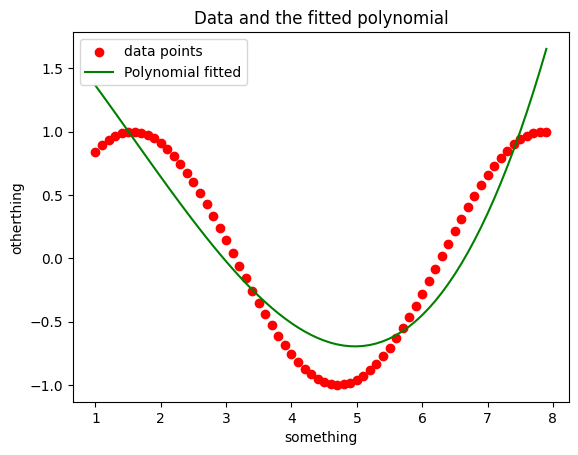

polynomial coeffs: [ 0.02085923 -0.09795982 -0.57375338  2.01481147]
predicted values for x=10 is: 7.3405230475527254


In [154]:
#Unknown that is to be find out : quality parameter
#Input: compression ratio
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline


def fit_polynomial(x,y,degree):
    """
        y=f(x)
    y is the quality: numpy array of y data points
    x is the compression ratio: numpy array of x data points
    degree: degree of the polynomial to be fit
    #returns the tuple containing the coefficints and the residuals
    """

    if len(x)!=len(y):
        raise ValueError("Length of the two lists must be same:")

    if degree<1:
        raise ValueError("Degree of the polynomial must be atleast 1")

    #convert the data to numpy arrays
    x=np.array(x)
    y=np.array(y)

    #fit the polynomial using curve fit
    coeffs=np.polyfit(x,y,degree)
    y_fit=np.polyval(coeffs,x)

    print("coeffs:",coeffs)

    return coeffs,y_fit,degree

def predict_value(coeffs,x,degree):
    return np.polyval(coeffs,x)


def plotting_data_fit(x,y,y_fit,coeffs,xlabel_="Independent_variable",ylabel_="Dependent_variable"):
    #plotting the real data and the fitted polynomial on the plot
    plt.scatter(x,y,color="red",label="data points")
    plt.plot(x,y_fit,color="green",label="Polynomial fitted")
    plt.title("Data and the fitted polynomial")
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.legend()
    plt.show()
    


def testing_function():
    """
        assume some data and then plot the fitted polynomial
        just for checking the fitting function
        """
    print("This is the testing function for the polynomial \
    fitting of the data and the input data is just assumed some \
    value")
    x=np.arange(1,8,0.1)
    y=np.sin(x)
    
    coeffs,y_fit,degree=fit_polynomial(x,y,3)

    plotting_data_fit(x,y,y_fit,coeffs,xlabel_="something",ylabel_="otherthing")
    
    #coeffs=fit_polynomial(x,y,degree)

    #y_fit=np.polyval(coeffs,x)
    
    print("polynomial coeffs:",coeffs)
    print("predicted values for x=10 is:",predict_value(coeffs,10,3))
    #x_smooth=np.linspace(min(x),max(x),100)
    #y_smooth=np.polyval(coeffs,x_smooth)
    #return coeffs,y_fit
    

    



#For testing only
testing_function()
    

coeffs: [-4.01977328e-04  8.63211258e-02 -5.95372819e+00  1.33912948e+02]
Polynomial fitting time: 0.001 seconds


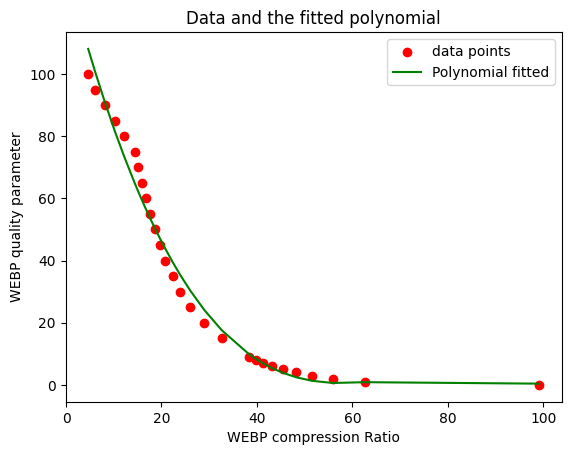

In [132]:
#here we want to fit a polynomial of some desired degree to the calibration data which is between the quality of the webp and the compression ratio 
# for a particular image
x=calib_data["CR"]
y=calib_data["Quality"]

#fitting the polynomial to these data
start=time.time()
coeffs,y_fit=fit_polynomial(x,y,3)
end=time.time()
print("Polynomial fitting time:",round(end-start,3),"seconds")
plotting_data_fit(x,y,y_fit,coeffs,"WEBP compression Ratio","WEBP quality parameter")




In [142]:
start=time.time()
compression_driver(image_path,5)
end=time.time()
print(f"total time :{round(end-start,2)}seconds")

Img compression:  0.47
CR:  0.0
Features:  0.07
KP O 89345 KP_R 54307
KP % red 39.21652023056691
total time :0.54seconds


Calibration data:
{'Quality': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'Compressed_size': [148866, 235370, 264036, 286380, 305746, 324574, 342396, 358128, 371262, 384620, 452000, 508866, 566526, 618276, 658634, 711914, 748856, 787168, 838032, 882914, 929950, 975662, 1022406, 1211400, 1442554, 1807704, 2433176, 3176916], 'CR': [99.11325621700053, 62.68680800441857, 55.88099350088624, 51.52103498847685, 48.257684483198474, 45.45833615754805, 43.09219149756422, 41.199219273555826, 39.74172956025664, 38.36148406219125, 32.642907079646015, 28.995047812194173, 26.043983859522776, 23.864089823962114, 22.40181041367436, 20.7252477125046, 19.702845406860597, 18.743894568884915, 17.606241766424194, 16.71124707502656, 15.866007849884403, 15.122649032144329, 14.431247469204992, 12.17978702327885, 10.228105152389443, 8.162063036868869, 6.063923859186512, 4.644313541812248]}
Execution time: 20.11
Images in dataset: 50
First filename: 00

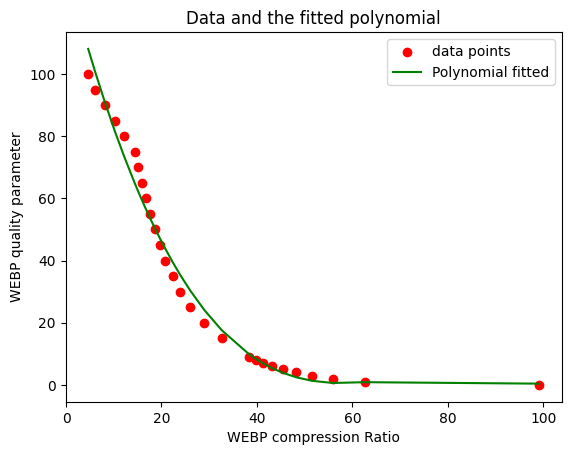

Img_org_size: 118.036752
Quality is: 2.929870431670423
Directory already exists- Removing the existing files
files_removed
Img_org_size: 118.036752
Quality is: 2.929870431670423
Quality calculated in the image_compression function : 2.929870431670423
Img compression:  0.42
CR:  0.0
Features:  0.07
KP O 89345 KP_R 49359
KP % red 44.75460294364542
Compression time:  0.4896 seconds
Compressed_size: 716656 bits
bandwidth_consumed: 1.4625632653061225 Mbps
Remaining bandwidth: 3.5374367346938778 Mbps


Img_org_size: 122.130568
Quality is: 1.8195331489395699
Quality calculated in the image_compression function : 1.8195331489395699
Img compression:  0.39
CR:  0.0
Features:  0.07
KP O 99484 KP_R 54100
KP % red 45.61939608379237
Compression time:  0.4631 seconds
Compressed_size: 718240 bits
bandwidth_consumed: 1.561391304347826 Mbps
Remaining bandwidth: 3.438608695652174 Mbps


Img_org_size: 120.776408
Quality is: 1.1728411990501115
Quality calculated in the image_compression function : 1.172841

In [163]:
#run Image compression
dataset_path=r"C:\Swapnil\Narrowband_DRONE\compression_data_experiment\images"

image_path=r"C:\Swapnil\Narrowband_DRONE\compression_experiment\images\000000_left.png"
start=time.time()
calib_data=calibration_function(image_path)
end=time.time()
print("Execution time:",round(end-start,2))

image_compression(dataset_path,calib_data)
